In [1]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.5.5
IPython 6.3.0

numpy 1.14.3
sklearn 0.19.1
scipy 1.0.1
matplotlib 2.2.2
tensorflow 1.8.0


**11장 – 심층 신경망 훈련**

_이 노트북은 11장에 있는 모든 샘플 코드를 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# 그래디언트 소실/폭주 문제

In [3]:
def logit(z):
    return 1 / (1 + np.exp(-z))

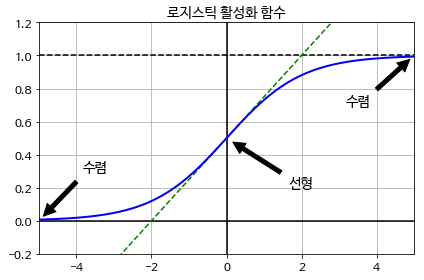

In [4]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('수렴', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('수렴', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('선형', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("로지스틱 활성화 함수", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier와 He 초기화

In [5]:
import tensorflow as tf

In [6]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [7]:
he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

## 수렴하지 않는 활성화 함수

### Leaky ReLU

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

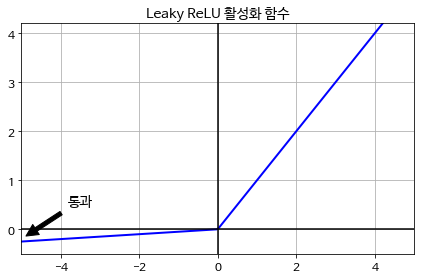

In [9]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('통과', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU 활성화 함수", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

텐서플로에서 Leaky ReLU 구현하기:

_텐서플로 1.4에서 tf.nn.leaky_\__relu(z, alpha) 함수가 추가되었습니다._

In [10]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [11]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Leaky ReLU를 사용하여 신경망을 훈련시켜 보죠. 먼저 그래프를 정의합니다:

In [12]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [13]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [14]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [15]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [16]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [17]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [18]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

데이터를 로드합니다:

In [19]:
from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)  # deprecated 경고 메세지를 출력하지 않기 위해 
mnist = input_data.read_data_sets("/tmp/data/")
tf.logging.set_verbosity(tf.logging.INFO)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [20]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "배치 정확도:", acc_train, "검증 세트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 배치 정확도: 0.86 검증 세트 정확도: 0.9044
5 배치 정확도: 0.94 검증 세트 정확도: 0.951
10 배치 정확도: 0.96 검증 세트 정확도: 0.9662
15 배치 정확도: 1.0 검증 세트 정확도: 0.9722
20 배치 정확도: 1.0 검증 세트 정확도: 0.9746
25 배치 정확도: 1.0 검증 세트 정확도: 0.9764
30 배치 정확도: 0.98 검증 세트 정확도: 0.978
35 배치 정확도: 0.96 검증 세트 정확도: 0.9794


### ELU

In [21]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

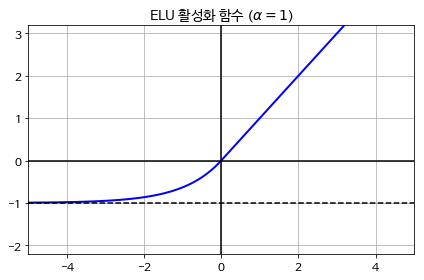

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU 활성화 함수 ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

텐서플로에서 ELU를 구현하는 것은 간단합니다. 층을 구성할 때 활성화 함수에 지정하기만 하면 됩니다:

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [24]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU

이 활성화 함수는 Günter Klambauer, Thomas Unterthiner, Andreas Mayr가 2017년에 쓴 [논문](https://arxiv.org/pdf/1706.02515.pdf)에서 소개되었습니다(나중에 책에 추가하겠습니다). 심층 신경망에서 다른 활성화 함수보다 뛰어난 성능을 내므로 꼭 이 함수를 시도해봐야 합니다.

In [25]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

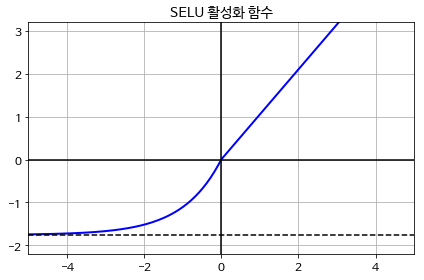

In [26]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU 활성화 함수", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

이 활성화 함수를 사용하면 100층으로 된 심층 신경망도 그래디언트 소실/폭주 문제없이 모든 층에서 대략 평균이 0이고 표준 편차가 1을 유지합니다:

In [27]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("층 {}: {:.2f} < 평균 < {:.2f}, {:.2f} < 표준 편차 < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

층 0: -0.26 < 평균 < 0.27, 0.74 < 표준 편차 < 1.27
층 10: -0.24 < 평균 < 0.27, 0.74 < 표준 편차 < 1.27
층 20: -0.17 < 평균 < 0.18, 0.74 < 표준 편차 < 1.24
층 30: -0.27 < 평균 < 0.24, 0.78 < 표준 편차 < 1.20
층 40: -0.38 < 평균 < 0.39, 0.74 < 표준 편차 < 1.25
층 50: -0.27 < 평균 < 0.31, 0.73 < 표준 편차 < 1.27
층 60: -0.26 < 평균 < 0.43, 0.74 < 표준 편차 < 1.35
층 70: -0.19 < 평균 < 0.21, 0.75 < 표준 편차 < 1.21
층 80: -0.18 < 평균 < 0.16, 0.72 < 표준 편차 < 1.19
층 90: -0.19 < 평균 < 0.16, 0.75 < 표준 편차 < 1.20


다음은 텐서플로를 사용한 구현 예입니다(텐서플로 1.4 버전에 `tf.nn.selu()` 함수가 추가되었습니다):

In [28]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

SELU는 드롭아웃과 연결하여 사용할 수 있습니다. Linz 대학교 생물정보학 연구소(Institute of Bioinformatics)의 Johannes Kepler가 만든 [구현](https://github.com/bioinf-jku/SNNs/blob/master/selu.py)을 확인해 보세요.

SELU 활성화 함수를 사용한 신경망을 만들어 MNIST 문제를 풀어 보겠습니다:

In [29]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

이제 훈련할 차례입니다. 입력을 평균 0, 표준 편차 1로 스케일 조정해야 합니다:

In [30]:
means = mnist.train.images.mean(axis=0, keepdims=True)
stds = mnist.train.images.std(axis=0, keepdims=True) + 1e-10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            X_val_scaled = (mnist.validation.images - means) / stds
            acc_test = accuracy.eval(feed_dict={X: X_val_scaled, y: mnist.validation.labels})
            print(epoch, "배치 정확도:", acc_train, "검증 세트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 배치 정확도: 0.96 검증 세트 정확도: 0.924
5 배치 정확도: 1.0 검증 세트 정확도: 0.9568
10 배치 정확도: 0.94 검증 세트 정확도: 0.967
15 배치 정확도: 0.98 검증 세트 정확도: 0.9686
20 배치 정확도: 1.0 검증 세트 정확도: 0.971
25 배치 정확도: 1.0 검증 세트 정확도: 0.9694
30 배치 정확도: 1.0 검증 세트 정확도: 0.97
35 배치 정확도: 1.0 검증 세트 정확도: 0.9712


# 배치 정규화

각 은닉층의 활성화 함수 전에 배치 정규화를 추가하기 위해 ELU 활성화 함수를 배치 정규화 층 이후에 수동으로 적용하겠습니다.

노트: `tf.layers.dense()` 함수가 (책에서 사용하는) `tf.contrib.layers.arg_scope()`와 호환되지 않기 때문에 대신 파이썬의 `functools.partial()` 함수를 사용합니다. 이를 사용해 `tf.layers.dense()`에 필요한 매개변수가 자동으로 설정되도록 `my_dense_layer()`를 만듭니다(그렇지 않으면 `my_dense_layer()`를 호출할 때마다 덮어씌여질 것입니다). 다른 코드는 이전과 비슷합니다.

In [31]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [32]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

같은 매개변수를 계속 반복해서 쓰지 않도록 파이썬의 `partial()` 함수를 사용합니다:

In [33]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

각 층에 ELU 활성화 함수와 배치 정규화를 사용하여 MNIST를 위한 신경망을 만듭니다:

In [34]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

노트: 배치 정규화를 위해 별도의 업데이트 연산을 실행해 주어야 합니다(`sess.run([training_op, extra_update_ops],...`).

In [35]:
n_epochs = 20
batch_size = 200

In [36]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "테스트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 테스트 정확도: 0.8666
1 테스트 정확도: 0.894
2 테스트 정확도: 0.9088
3 테스트 정확도: 0.9189
4 테스트 정확도: 0.9262
5 테스트 정확도: 0.9334
6 테스트 정확도: 0.9379
7 테스트 정확도: 0.9419
8 테스트 정확도: 0.9444
9 테스트 정확도: 0.9477
10 테스트 정확도: 0.9499
11 테스트 정확도: 0.952
12 테스트 정확도: 0.9546
13 테스트 정확도: 0.956
14 테스트 정확도: 0.9567
15 테스트 정확도: 0.9591
16 테스트 정확도: 0.9609
17 테스트 정확도: 0.9612
18 테스트 정확도: 0.9618
19 테스트 정확도: 0.9635


어!? MNIST 정확도가 좋지 않네요. 물론 훈련을 더 오래하면 정확도가 높아지겠지만 이런 얕은 신경망에서는 배치 정규화와 ELU가 큰 효과를 내지 못합니다. 대부분 심층 신경망에서 빛을 발합니다.

업데이트 연산에 의존하는 훈련 연산을 만들 수도 있습니다:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

이렇게 하면 훈련할 때 `training_op`만 평가하면 텐서플로가 업데이트 연산도 자동으로 실행할 것입니다:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

한가지 더, 훈련될 변수 개수가 전체 전역 변수 개수보다 적습니다. 이동 평균을 위한 변수는 훈련되는 변수가 아니기 때문입니다. 미리 학습한 신경망을 재사용할 경우(아래 참조) 이런 훈련되지 않는 변수를 놓쳐서는 안됩니다.

In [37]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [38]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## 그래디언트 클리핑

MNIST를 위한 간단한 신경망을 만들고 그래디언트 클리핑을 적용해 보겠습니다. 시작 부분은 이전과 동일합니다(학습한 모델을 재사용하는 예를 만들기 위해 몇 개의 층을 더 추가했습니다. 아래 참조):

In [39]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [40]:
learning_rate = 0.01

이제 그래디언트 클리핑을 적용합니다. 먼저 그래디언트를 구한 다음 `clip_by_value()` 함수를 사용해 클리핑하고 적용합니다:

In [41]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

나머지는 이전과 동일합니다:

In [42]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [43]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [44]:
n_epochs = 20
batch_size = 200

In [45]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "테스트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 테스트 정확도: 0.3138
1 테스트 정확도: 0.8001
2 테스트 정확도: 0.881
3 테스트 정확도: 0.904
4 테스트 정확도: 0.9122
5 테스트 정확도: 0.9195
6 테스트 정확도: 0.9245
7 테스트 정확도: 0.9301
8 테스트 정확도: 0.9331
9 테스트 정확도: 0.9389
10 테스트 정확도: 0.943
11 테스트 정확도: 0.9449
12 테스트 정확도: 0.9456
13 테스트 정확도: 0.9485
14 테스트 정확도: 0.9524
15 테스트 정확도: 0.9519
16 테스트 정확도: 0.9563
17 테스트 정확도: 0.9583
18 테스트 정확도: 0.956
19 테스트 정확도: 0.9608


## 학습된 모델 재사용하기

## 텐서플로 모델 재사용하기

먼저 그래프 구조를 로드해야 합니다. `import_meta_graph()` 함수가 그래프 연산들을 로드하여 기본 그래프에 적재하고 모델의 상태를 복원할 수 있도록 `Saver` 객체를 반환합니다. 기본적으로 `Saver` 객체는 `.meta` 확장자를 가진 파일에 그래프 구조를 저장하므로 이 파일을 로드해야 합니다:

In [46]:
reset_graph()

In [47]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

다음으로 훈련해야 할 모든 연산을 가져와야 합니다. 그래프 구조를 모를 때는 모든 연산을 출력해 볼 수 있습니다:

In [48]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

save/RestoreV2/shape_and_slices
save/RestoreV2/tensor_names
save/SaveV2/shape_and_slices
save/SaveV2/tensor_names
save/Const
save/RestoreV2
eval/Const
eval/in_top_k/InTopKV2/k
GradientDescent/learning_rate
clip_by_value_11/clip_value_max
clip_by_value_11/clip_value_min
clip_by_value_10/clip_value_max
clip_by_value_10/clip_value_min
clip_by_value_9/clip_value_max
clip_by_value_9/clip_value_min
clip_by_value_8/clip_value_max
clip_by_value_8/clip_value_min
clip_by_value_7/clip_value_max
clip_by_value_7/clip_value_min
clip_by_value_6/clip_value_max
clip_by_value_6/clip_value_min
clip_by_value_5/clip_value_max
clip_by_value_5/clip_value_min
clip_by_value_4/clip_value_max
clip_by_value_4/clip_value_min
clip_by_value_3/clip_value_max
clip_by_value_3/clip_value_min
clip_by_value_2/clip_value_max
clip_by_value_2/clip_value_min
clip_by_value_1/clip_value_max
clip_by_value_1/clip_value_min
clip_by_value/clip_value_max
clip_by_value/clip_value_min
gradients/loss/SparseSoftmaxCrossEntropyWithLogits

웁스, 연산이 엄청 많네요! 텐서보드로 그래프를 시각화해보는 것이 더 좋을 것 같습니다. 다음 코드는 주피터에서 그래프를 그려줍니다(만약 브라우저에서 보이지 않는다면 `FileWriter`로 그래프를 저장한 다음 텐서보드에서 열어 보세요):

In [49]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [50]:
show_graph(tf.get_default_graph())

필요한 연산을 찾았다면 그래프의 `get_operation_by_name()`이나 `get_tensor_by_name()` 메서드를 사용하여 추출할 수 있습니다:

In [51]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

원본 모델을 만들 때 다른 사람이 재사용하기 쉽게 연산에 명확한 이름을 부여하고 문서화를 하는 것이 좋습니다. 또 다른 방법은 처리해야 할 중요한 연산들을 모두 모아 놓은 컬렉션을 만드는 것입니다:

In [52]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

이렇게 하면 모델을 재사용할 때 다음과 같이 간단하게 쓸 수 있습니다:

In [53]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

이제 세션을 시작하고 모델을 복원하여 준비된 훈련 데이터로 훈련을 계속할 수 있습니다:

In [54]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # 모델 훈련 계속하기...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


실제로 테스트를 해보죠!

In [55]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "테스트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 테스트 정확도: 0.9607
1 테스트 정확도: 0.9611
2 테스트 정확도: 0.962
3 테스트 정확도: 0.961
4 테스트 정확도: 0.9643
5 테스트 정확도: 0.9653
6 테스트 정확도: 0.9665
7 테스트 정확도: 0.9628
8 테스트 정확도: 0.9663
9 테스트 정확도: 0.967
10 테스트 정확도: 0.9668
11 테스트 정확도: 0.9674
12 테스트 정확도: 0.9675
13 테스트 정확도: 0.9682
14 테스트 정확도: 0.9688
15 테스트 정확도: 0.9685
16 테스트 정확도: 0.9687
17 테스트 정확도: 0.9701
18 테스트 정확도: 0.9678
19 테스트 정확도: 0.9687


또 다른 방법으로 원본 그래프를 만든 파이썬 코드에 접근할 수 있다면 `import_meta_graph()`를 대신 사용할 수 있습니다:

In [56]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

그 다음 훈련을 계속할 수 있습니다:

In [57]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "테스트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 테스트 정확도: 0.9612
1 테스트 정확도: 0.9617
2 테스트 정확도: 0.9625
3 테스트 정확도: 0.9617
4 테스트 정확도: 0.9646
5 테스트 정확도: 0.9637
6 테스트 정확도: 0.9647
7 테스트 정확도: 0.9648
8 테스트 정확도: 0.9669
9 테스트 정확도: 0.968
10 테스트 정확도: 0.9678
11 테스트 정확도: 0.9678
12 테스트 정확도: 0.9687
13 테스트 정확도: 0.9686
14 테스트 정확도: 0.9685
15 테스트 정확도: 0.9694
16 테스트 정확도: 0.9682
17 테스트 정확도: 0.9694
18 테스트 정확도: 0.9695
19 테스트 정확도: 0.9707


일반적으로 하위층만 재사용할 것입니다. `import_meta_graph()`를 사용하면 전체 그래프를 로드하지만 필요하지 않은 부분은 무시하면 됩니다. 이 예에서는 학습된 3번째 층 위에 4번째 은닉층을 새로 추가합니다(원래 4번째 층은 무시됩니다). 새로운 출력층도 추가하고 이 출력으로 손실을 계산하고 이를 최소화하기 위한 새로운 옵티마이저를 만듭니다. 전체 그래프(원본 그래프 전체와 새로운 연산)를 저장할 새로운 `Saver` 객체와 새로운 모든 변수를 초기화할 초기화 연산도 필요합니다:

In [58]:
reset_graph()

n_hidden4 = 20  # 새 층
n_outputs = 10  # 새 층

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

새로운 모델을 훈련시킵니다:

In [59]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "테스트 정확도:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 테스트 정확도: 0.9236
1 테스트 정확도: 0.9383
2 테스트 정확도: 0.9492
3 테스트 정확도: 0.9526
4 테스트 정확도: 0.9566
5 테스트 정확도: 0.9577
6 테스트 정확도: 0.9596
7 테스트 정확도: 0.961
8 테스트 정확도: 0.9623
9 테스트 정확도: 0.9626
10 테스트 정확도: 0.9642
11 테스트 정확도: 0.9628
12 테스트 정확도: 0.9641
13 테스트 정확도: 0.9655
14 테스트 정확도: 0.9655
15 테스트 정확도: 0.9662
16 테스트 정확도: 0.9676
17 테스트 정확도: 0.9686
18 테스트 정확도: 0.9687
19 테스트 정확도: 0.9693


원본 모델을 만든 파이썬 코드에 접근할 수 있다면 필요한 부분만 재사용하고 나머지는 버릴 수 있습니다:

In [60]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 재사용
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

그러나 이전에 학습된 모델을 복원하기 위해 (복원할 변수 리스트를 전달합니다. 그렇지 않으면 그래프와 맞지 않는다고 에러를 낼 것입니다) `Saver` 객체를 하나 만들고 훈련이 끝난 후 새로운 모델을 저장하기 위해 또 다른 `Saver` 객체를 만들어야 합니다:

In [61]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                      # 책에는 없음
        for iteration in range(mnist.train.num_examples // batch_size): # 책에는 없음
            X_batch, y_batch = mnist.train.next_batch(batch_size)      # 책에는 없음
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})  # 책에는 없음
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,  # 책에는 없음
                                                y: mnist.test.labels}) # 책에는 없음
        print(epoch, "테스트 정확도:", accuracy_val)                   # 책에는 없음

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 테스트 정확도: 0.9026
1 테스트 정확도: 0.9307
2 테스트 정확도: 0.9394
3 테스트 정확도: 0.943
4 테스트 정확도: 0.9482
5 테스트 정확도: 0.951
6 테스트 정확도: 0.9514
7 테스트 정확도: 0.9539
8 테스트 정확도: 0.9545
9 테스트 정확도: 0.9569
10 테스트 정확도: 0.9597
11 테스트 정확도: 0.9599
12 테스트 정확도: 0.9604
13 테스트 정확도: 0.962
14 테스트 정확도: 0.9619
15 테스트 정확도: 0.9634
16 테스트 정확도: 0.963
17 테스트 정확도: 0.9647
18 테스트 정확도: 0.9653
19 테스트 정확도: 0.9659


## 다른 프레임워크의 모델 재사용하기

이 예에서는 재사용하려는 각 변수에 대해 변수 초기화 할당 연산을 찾고, 초기화 될 값에 해당하는 두 번째 입력 핸들을 구합니다. 초기화가 실행될 때 여기에 `feed_dict` 매개변수를 사용하여 초깃값 대신 원하는 값을 주입합니다:

In [62]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [63]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # 다른 프레임워크로부터 가중치를 로드
original_b = [7., 8., 9.]                 # 다른 프레임워크로부터 편향을 로드

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] 모델의 나머지 부분을 구성

# hidden1 변수의 할당 노드에 대한 핸들을 구합니다
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] 새 작업에 모델을 훈련시킵니다
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # 책에는 없음

[[ 61.  83. 105.]]


또 다른 방법은 전용 할당 노드와 플레이스홀더를 만든는 것입니다. 이 방법은 더 번거롭고 효율적이지 않지만 하려는 방식이 잘 드러나는 방법입니다:

In [64]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # 다른 프레임워크로부터 가중치를 로드
original_b = [7., 8., 9.]                 # 다른 프레임워크로부터 편향을 로드

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] 모델의 나머지를 구성

# hidden1 변수의 할당 노드에 대한 핸들을 구합니다
with tf.variable_scope("", default_name="", reuse=True):  # 루트 범위
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# 전용 플레이스홀더와 할당 노드를 만듭니다
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] 새 작업에 모델을 훈련시킵니다
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


`get_collection()`에 `scope`를 지정하여 변수의 핸들을 가져올 수도 있습니다:

In [65]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

또는 그래프의 `get_tensor_by_name()` 메서드를 사용할 수 있습니다:

In [66]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [67]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### 하위층 동결하기

In [68]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 재사용
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [69]:
with tf.name_scope("train"):                                         # 책에는 없음
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # 책에는 없음
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [70]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [71]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "테스트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 테스트 정확도: 0.8987
1 테스트 정확도: 0.931
2 테스트 정확도: 0.9371
3 테스트 정확도: 0.9418
4 테스트 정확도: 0.9437
5 테스트 정확도: 0.9477
6 테스트 정확도: 0.9494
7 테스트 정확도: 0.9524
8 테스트 정확도: 0.9513
9 테스트 정확도: 0.9522
10 테스트 정확도: 0.9536
11 테스트 정확도: 0.9538
12 테스트 정확도: 0.9536
13 테스트 정확도: 0.9548
14 테스트 정확도: 0.9537
15 테스트 정확도: 0.9552
16 테스트 정확도: 0.9552
17 테스트 정확도: 0.9551
18 테스트 정확도: 0.9552
19 테스트 정확도: 0.9554


In [72]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [73]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # 동결층 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # 동결층 재사용
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # 동결하지 않고 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # 새로 만듦!

In [74]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

훈련하는 코드는 이전과 완전히 동일합니다:

In [75]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "테스트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 테스트 정확도: 0.9035
1 테스트 정확도: 0.932
2 테스트 정확도: 0.9398
3 테스트 정확도: 0.9435
4 테스트 정확도: 0.9471
5 테스트 정확도: 0.949
6 테스트 정확도: 0.9499
7 테스트 정확도: 0.9492
8 테스트 정확도: 0.9518
9 테스트 정확도: 0.9521
10 테스트 정확도: 0.9529
11 테스트 정확도: 0.9536
12 테스트 정확도: 0.953
13 테스트 정확도: 0.9535
14 테스트 정확도: 0.9525
15 테스트 정확도: 0.9538
16 테스트 정확도: 0.953
17 테스트 정확도: 0.9551
18 테스트 정확도: 0.9549
19 테스트 정확도: 0.9555


### 동결층 캐싱하기

In [76]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # 동결층 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # 동결층 재사용 & 캐싱
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # 동결하지 않고 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [77]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [78]:
import numpy as np

n_batches = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: mnist.train.images})
    h2_cache_test = sess.run(hidden2, feed_dict={X: mnist.test.images}) # 책에는 없음

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(mnist.train.num_examples)
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(mnist.train.labels[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_test, # 책에는 없음
                                                y: mnist.test.labels})  # 책에는 없음
        print(epoch, "테스트 정확도:", accuracy_val)                    # 책에는 없음

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 테스트 정확도: 0.9021
1 테스트 정확도: 0.9319
2 테스트 정확도: 0.9425
3 테스트 정확도: 0.945
4 테스트 정확도: 0.9473
5 테스트 정확도: 0.9481
6 테스트 정확도: 0.951
7 테스트 정확도: 0.9507
8 테스트 정확도: 0.9515
9 테스트 정확도: 0.9524
10 테스트 정확도: 0.9513
11 테스트 정확도: 0.9523
12 테스트 정확도: 0.9522
13 테스트 정확도: 0.954
14 테스트 정확도: 0.9539
15 테스트 정확도: 0.9537
16 테스트 정확도: 0.9547
17 테스트 정확도: 0.954
18 테스트 정확도: 0.9538
19 테스트 정확도: 0.9547


# 고속 옵티마이저

## 모멘텀 옵티마이저

In [79]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

## 네스테로프 가속 경사

In [80]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

In [81]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

In [82]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam 최적화

In [83]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## 학습률 스케줄링

In [84]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [85]:
with tf.name_scope("train"):       # 책에는 없음
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [86]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [87]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "테스트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 테스트 정확도: 0.9579
1 테스트 정확도: 0.9708
2 테스트 정확도: 0.9731
3 테스트 정확도: 0.9793
4 테스트 정확도: 0.9798


# 규제로 과대적합 피하기

## $\ell_1$과 $\ell_2$ 규제

$\ell_1$ 규제를 직접 구현해 보죠. 먼저 평상시처럼 모델을 만듭니다(간단하게 하기 위해 은닉층을 하나만 두겠습니다):

In [88]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

그다음, 층의 가중치에 대한 핸들을 얻어 크로스 엔트로피 손실에 $\ell_1$ 손실(즉, 가중치의 절댓값)을 더해 전체 손실을 계산합니다:

In [89]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 규제 하이퍼파라미터

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

나머지는 이전과 동일합니다:

In [90]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [91]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "테스트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 테스트 정확도: 0.8343
1 테스트 정확도: 0.8726
2 테스트 정확도: 0.8832
3 테스트 정확도: 0.8899
4 테스트 정확도: 0.8959
5 테스트 정확도: 0.8986
6 테스트 정확도: 0.9011
7 테스트 정확도: 0.9032
8 테스트 정확도: 0.9046
9 테스트 정확도: 0.9047
10 테스트 정확도: 0.9065
11 테스트 정확도: 0.9059
12 테스트 정확도: 0.9072
13 테스트 정확도: 0.9072
14 테스트 정확도: 0.9069
15 테스트 정확도: 0.9071
16 테스트 정확도: 0.9064
17 테스트 정확도: 0.9071
18 테스트 정확도: 0.9068
19 테스트 정확도: 0.9063


다른 방법으로는 `tf.layers.dense()` 함수에 규제 함수를 전달할 수 있습니다. 이 함수는 규제 손실을 계산하기 위한 연산을 만들고 규제 손실 컬렉션에 이 연산을 추가합니다. 모델 선언부는 이전과 동일합니다:

In [92]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

그다음, 동일한 매개변수를 매번 반복하지 않으려고 파이썬의 `partial()` 함수를 사용합니다. `kernel_regularizer` 매개변수를 지정해야 합니다:

In [93]:
scale = 0.001

In [94]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

기본 손실에 규제 손실을 추가합니다:

In [95]:
with tf.name_scope("loss"):                                     # 책에는 없음
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # 책에는 없음
        labels=y, logits=logits)                                # 책에는 없음
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # 책에는 없음
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

나머지는 평상시와 동일합니다:

In [96]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [97]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "테스트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 테스트 정확도: 0.8299
1 테스트 정확도: 0.8778
2 테스트 정확도: 0.8915
3 테스트 정확도: 0.9016
4 테스트 정확도: 0.9068
5 테스트 정확도: 0.9103
6 테스트 정확도: 0.9124
7 테스트 정확도: 0.9137
8 테스트 정확도: 0.9149
9 테스트 정확도: 0.9175
10 테스트 정확도: 0.9176
11 테스트 정확도: 0.9184
12 테스트 정확도: 0.9191
13 테스트 정확도: 0.9182
14 테스트 정확도: 0.9195
15 테스트 정확도: 0.9201
16 테스트 정확도: 0.918
17 테스트 정확도: 0.9184
18 테스트 정확도: 0.9181
19 테스트 정확도: 0.9174


## 드롭아웃

In [98]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [99]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [100]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [101]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 테스트 정확도: 0.9205
1 테스트 정확도: 0.942
2 테스트 정확도: 0.9469
3 테스트 정확도: 0.9511
4 테스트 정확도: 0.9542
5 테스트 정확도: 0.9569
6 테스트 정확도: 0.961
7 테스트 정확도: 0.9598
8 테스트 정확도: 0.9612
9 테스트 정확도: 0.9656
10 테스트 정확도: 0.9662
11 테스트 정확도: 0.9616
12 테스트 정확도: 0.9663
13 테스트 정확도: 0.9668
14 테스트 정확도: 0.965
15 테스트 정확도: 0.9678
16 테스트 정확도: 0.9696
17 테스트 정확도: 0.9674
18 테스트 정확도: 0.9694
19 테스트 정확도: 0.9683


## 맥스 노름

2개의 은닉층을 가진 간단한 MNIST 신경망을 만들어 보겠습니다:

In [102]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

다음으로 첫 번째 은닉층의 가중치에 대한 핸들을 얻고 `clip_by_norm()` 함수를 사용해 가중치를 클리핑하는 연산을 만듭니다. 그런 다음 클리핑된 가중치를 가중치 변수에 할당하는 연산을 만듭니다:

In [103]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

두 번째 층에 대해서도 동일하게 할 수 있습니다:

In [104]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

초기와 연산과 `Saver` 객체를 만듭니다:

In [105]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

이제 모델을 훈련시킵니다. 이전과 매우 동일한데 `training_op`을 실행한 후에 `clip_weights`와 `clip_weights2` 연산을 실행하는 것만 다릅니다:

In [106]:
n_epochs = 20
batch_size = 50

In [107]:
with tf.Session() as sess:                                              # 책에는 없음
    init.run()                                                          # 책에는 없음
    for epoch in range(n_epochs):                                       # 책에는 없음
        for iteration in range(mnist.train.num_examples // batch_size):  # 책에는 없음
            X_batch, y_batch = mnist.train.next_batch(batch_size)       # 책에는 없음
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # 책에는 없음
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,       # 책에는 없음
                                            y: mnist.test.labels})      # 책에는 없음
        print(epoch, "테스트 정확도:", acc_test)                        # 책에는 없음

    save_path = saver.save(sess, "./my_model_final.ckpt")               # 책에는 없음

0 테스트 정확도: 0.9512
1 테스트 정확도: 0.9671
2 테스트 정확도: 0.972
3 테스트 정확도: 0.9757
4 테스트 정확도: 0.975
5 테스트 정확도: 0.9757
6 테스트 정확도: 0.9777
7 테스트 정확도: 0.9796
8 테스트 정확도: 0.9806
9 테스트 정확도: 0.9798
10 테스트 정확도: 0.9813
11 테스트 정확도: 0.9809
12 테스트 정확도: 0.9817
13 테스트 정확도: 0.9804
14 테스트 정확도: 0.9819
15 테스트 정확도: 0.9823
16 테스트 정확도: 0.9833
17 테스트 정확도: 0.9827
18 테스트 정확도: 0.9825
19 테스트 정확도: 0.9822


위 구현은 이해하기 쉽고 잘 작동하지만 조금 번거롭습니다. 더 나은 방법은 `max_norm_regularizer()` 함수를 만드는 것입니다:

In [108]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # 규제 손실을 위한 항이 없습니다
    return max_norm

그런 다음 (필요한 임계값을 지정해서) 맥스 노름 규제 매개변수에 넘길 함수를 만들기 위해 이 함수를 호출합니다. 은닉층을 만들 때 이 규제 함수를 `kernel_regularizer` 매개변수를 통해 전달할 수 있습니다:

In [109]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [110]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [111]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

훈련 연산이 실행된 후에 가중치 클리핑 연산을 실행하는 것을 제외하면 이전과 동일합니다:

In [112]:
n_epochs = 20
batch_size = 50

In [113]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,     # 책에는 없음
                                            y: mnist.test.labels})    # 책에는 없음
        print(epoch, "테스트 정확도:", acc_test)                      # 책에는 없음

    save_path = saver.save(sess, "./my_model_final.ckpt")             # 책에는 없음

0 테스트 정확도: 0.954
1 테스트 정확도: 0.9657
2 테스트 정확도: 0.9707
3 테스트 정확도: 0.9743
4 테스트 정확도: 0.9761
5 테스트 정확도: 0.9777
6 테스트 정확도: 0.9775
7 테스트 정확도: 0.979
8 테스트 정확도: 0.9769
9 테스트 정확도: 0.9803
10 테스트 정확도: 0.9803
11 테스트 정확도: 0.9798
12 테스트 정확도: 0.9818
13 테스트 정확도: 0.9813
14 테스트 정확도: 0.9811
15 테스트 정확도: 0.9806
16 테스트 정확도: 0.9812
17 테스트 정확도: 0.9819
18 테스트 정확도: 0.9822
19 테스트 정확도: 0.982


# 연습문제 해답

11장의 연습문제는 [11_deep_learning_exercise](11_deep_learning_exercises.ipynb) 노트북에 있습니다.